In [1]:
import pandas as pd
from utils import *
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import trange, tqdm
from time import sleep
from component_store import GeneticAlgorithmComponent
import numpy as np
from evaluation import *
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
population_size = 50
brackets_per_individual = 5
test_brackets = 100
features = best_features

# Internals

In [4]:


results = run_pipe(2017, 2022, 2016, features)
train_acc, test_acc, clf = results
print(train_acc, test_acc)
features

test_year = 2023
test_df = get_training_data([test_year])
test_X = column_selector(test_df, features)
test_y = test_df['result']

df = pd.read_csv(f"{DATA_DIR}/cleaned_bracket_data.csv", index_col=0)
df = df[(df["year"] == test_year) & (df["round"] == 1)]
start_team_names = df[["team1", "team2"]].reset_index().melt(id_vars=['index'], value_vars=['team1', 'team2']).sort_values(["index", "variable"]).reset_index(drop=True)["value"]
start_team_names = pd.merge(start_team_names, df[["team1", "team1seed"]], how="left", left_on="value", right_on="team1").rename({"team1seed":"SEED"}, axis=1).drop("team1", axis=1)
start_team_names = pd.merge(start_team_names, df[["team2", "team2seed"]], how="left", left_on="value", right_on="team2").drop("team2", axis=1)
start_team_names.loc[start_team_names["SEED"].isna(), "SEED"] = start_team_names["team2seed"]
start_team_names = start_team_names.drop("team2seed", axis=1)

raw_brackets = generate_brackets_np(clf, features, start_team_names, test_year, (population_size * brackets_per_individual)+test_brackets)
print(raw_brackets.shape)

1.0 0.7686567164179104


100%|██████████| 350/350 [01:17<00:00,  4.49it/s]

(350, 63)


In [ ]:
def get_team_names(year):
    df = pd.read_csv(f"{DATA_DIR}/cleaned_bracket_data.csv", index_col=0)
    df = df[(df["year"] == year) & (df["round"] == 1)]
    start_team_names = df[["team1", "team2"]].reset_index().melt(id_vars=['index'], value_vars=['team1', 'team2']).sort_values(["index", "variable"]).reset_index(drop=True)["value"]
    start_team_names = pd.merge(start_team_names, df[["team1", "team1seed"]], how="left", left_on="value", right_on="team1").rename({"team1seed":"SEED"}, axis=1).drop("team1", axis=1)
    start_team_names = pd.merge(start_team_names, df[["team2", "team2seed"]], how="left", left_on="value", right_on="team2").drop("team2", axis=1)
    start_team_names.loc[start_team_names["SEED"].isna(), "SEED"] = start_team_names["team2seed"]
    start_team_names = start_team_names.drop("team2seed", axis=1)
    return start_team_names


In [ ]:
get_team_names(2023)

In [ ]:
brackets, test_set = raw_brackets[:-test_brackets], raw_brackets[-test_brackets:]
brackets = brackets.reshape((population_size, brackets_per_individual, 63))

In [ ]:
init_pop = brackets.copy()
init_pop.shape

In [ ]:
def data_setup(train_start, train_end, test_year, team_names, population_size, brackets_per_individual=5, test_brackets=100):
    train_acc, test_acc, clf = run_pipe(train_start, train_end, train_start-1, features)
    print(train_acc, test_acc)
    raw_brackets = generate_brackets_np(clf, features, team_names, test_year, (population_size * brackets_per_individual)+test_brackets)
    print(raw_brackets.shape)
    brackets, test_set = raw_brackets[:-test_brackets], raw_brackets[-test_brackets:]
    brackets = brackets.reshape((population_size, brackets_per_individual, 63))
    return brackets, test_set
init_pop, test_set = data_setup(2018, 2023, 2024, start_team_names, population_size)

In [ ]:
def eval_on_bracket(ind_true_bracket, init_pop):
    ind_true_bracket = np.tile(ind_true_bracket, [init_pop.shape[0], init_pop.shape[1], 1])
    results = init_pop == ind_true_bracket
    population_size, brackets_per_individual, _ = init_pop.shape
    preds = init_pop.copy()

    rounds =  [i + 2 for i in range(5)]
    round_lens = [16 // 2 ** (round - 2) for round in rounds]
    start_inds = [32, 32+16, 32+16+8, 32+16+8+4, 32+16+8+4+2]

    arr = []
    for i in range(6):
        arr = arr + [(2**i)]*(32//(2**i))
    point_values = np.tile(np.array(arr), (population_size, brackets_per_individual, 1))


    for round, round_len, start_ind in zip(rounds, round_lens, start_inds):
        for game in [start_ind + i for i in range(round_len)]:
            prereq_game_ind = (game-(2*round_len) + (game - start_ind) + (preds[:, :, game]).astype(int))#.reshape(2, 1, 1)
            prereq_results = results[:, :, prereq_game_ind][np.arange(population_size), :, np.arange(population_size), :][:, np.arange(brackets_per_individual), np.arange(brackets_per_individual)].reshape(results[:, :, game].shape)
            updated_results = np.logical_and(prereq_results, results[:, :, game])
            results[:, :, game] = updated_results

    fitness_per_individual = (point_values * results).sum(axis=2).max(axis=1)
    return fitness_per_individual

def fitness(init_pop, test_set):
    # TODO: vectorize this to improve efficiency for larger test sets
    return np.apply_along_axis(eval_on_bracket, 1, test_set, init_pop).mean(axis=0)

def softmax(x, em=1):
    em_x = x**em
    e_x = np.exp(em_x - em_x.max())
    return e_x / e_x.sum()

def selection(population, fitnesses, num_elites=0, emphasis=1):
    # print(softmax(fitnesses, emphasis))
    pop_size = population.shape[0]
    num_children_needed = population.shape[0] - num_elites
    # print(pop_size, num_children_needed)
    left_inds = np.random.choice(pop_size, num_children_needed, True, softmax(fitnesses, emphasis))
    right_inds = np.random.choice(pop_size, num_children_needed, True, softmax(fitnesses, emphasis))
    # print(left_inds)
    return population[left_inds], population[right_inds]

def combine(left_parents, right_parents):
    mask = np.random.binomial(1, 0.5, left_parents.shape)
    children = left_parents.copy()
    children[mask == 1] = right_parents[mask == 1]
    return children

def mutate(init_pop, mutation_rate):
    noise = np.random.binomial(1, mutation_rate, init_pop.shape)
    new_pop = np.logical_xor(init_pop, noise).astype(int)
    return new_pop

def generation(population, test_set, num_elites=3, emph=0.75, mr=1/1000):
    fitnesses = fitness(population, test_set)

    left_parents, right_parents = selection(population, fitnesses, num_elites=num_elites, emphasis=emph)
    children = mutate(combine(left_parents, right_parents), mutation_rate=mr)
    # print(children.shape)
    if num_elites > 0:
        elite_inds = np.argsort(fitnesses)[-num_elites:]
        elites = population[elite_inds]

        new_population = np.concatenate((children, elites), axis=0)
    else:
        new_population = children
    return new_population

def print_individual(individual):
    for bracket_ind in range(individual.shape[0]):
        round_1 = start_team_names.iloc[((np.arange(32) * 2) + individual[bracket_ind][:32])].reset_index(drop=True)
        round_2 = round_1.iloc[((np.arange(16) * 2) + individual[bracket_ind][32:32+16])].reset_index(drop=True)
        round_3 = round_2.iloc[((np.arange(8) * 2) + individual[bracket_ind][32+16:32+16+8])].reset_index(drop=True)
        round_4 = round_3.iloc[((np.arange(4) * 2) + individual[bracket_ind][32+16+8:32+16+8+4])].reset_index(drop=True)
        round_5 = round_4.iloc[((np.arange(2) * 2) + individual[bracket_ind][32+16+8+4:32+16+8+4+2])].reset_index(drop=True)
        round_6 = round_5.iloc[((np.arange(1) * 2) + individual[bracket_ind][32+16+8+4+2:32+16+8+4+2+1])].reset_index(drop=True)
        print(pd.concat([round_1, round_2, round_3, round_4, round_5, round_6], axis=1).fillna(""))


# run GA

In [ ]:
init_pop.shape

In [ ]:
test_set.shape

In [ ]:
# pop = init_pop.copy()
pop = np.random.binomial(1, 0.5, init_pop.shape)

In [ ]:
num_elites = 1
emph = 0.75
mr=1/1000
test_subset_size = 40

In [ ]:
def run_gym(
        pop,
        num_elites = 1, 
        emph = 0.75, 
        mr=1/1000, 
        test_subset_size = 40, 
        num_gens = 10000, 
        log_fitness=True, 
        log_freq=1000, 
        change_hps=True,
        early_stop=True
):  
    last_fitness = 0.0
    best_fits = np.zeros((1))
    mean_fits = np.zeros((1))
    for i in trange(num_gens):
        if change_hps:
            test_subset_size = min(min(test_brackets, 100), int(1/50 * i + 10))
            mr = 1/(i+100)
        test_subset = test_set[np.random.choice(np.arange(test_set.shape[0]), min(test_subset_size, test_set.shape[0]), False)]
        pop = generation(pop, test_subset, num_elites=num_elites, emph=emph, mr=mr)
        # print(fits[-1])
        if log_fitness and (i % log_freq == 0):
            fits = fitness(pop, test_set)
            best_fits = np.concatenate((best_fits, [fits.max()]))
            mean_fits = np.concatenate((mean_fits, [fits.mean()]))
            if early_stop and (fits.max() < last_fitness*1.001):
                return pop, best_fits, mean_fits
    
    return pop, best_fits, mean_fits
_pop, _best_fits, _mean_fits = run_gym(init_pop.copy(), log_freq=2, num_gens=200)
pop, best_fits, mean_fits = run_gym(np.random.binomial(1, 0.5, init_pop.shape), log_freq=2, num_gens=200)

In [ ]:

for test_year in [2023 - i for i in range(14)]:
    print(test_year)

In [ ]:
all_results = None

for test_year in [2023 - i for i in range(14)]:
    if test_year > 2020:
        train_start = test_year - 6
    elif test_year < 2020:
        train_start = test_year - 5
    else:
        continue
    train_end = test_year - 1
    print(test_year)
    start_team_names = get_team_names(test_year)
    init_pop, test_set = data_setup(train_start, train_end, test_year, start_team_names, population_size)

    for num_elites in [5]:
        for emph in [1]:
            for mr in [1/1000]:
                for test_subset_size in [20]:
                    for num_gens in [1000]:
                        print(train_start, train_end, test_year, num_elites, emph, mr, test_subset_size, num_gens)

                        pop, best_fits, mean_fits = run_gym(
                            init_pop.copy(), 
                            num_elites=num_elites,
                            emph =emph, 
                            mr=mr, 
                            test_subset_size=test_subset_size, 
                            num_gens=num_gens, 
                            log_fitness=False
                        )
                        fitnesses = fitness(pop, test_set)
                        best_fit, mean_fit = fitnesses.max(), fitnesses.mean()
                        all_results = pd.concat((all_results, pd.DataFrame(
                            [[train_start, train_end, test_year, num_elites, emph, mr, test_subset_size, num_gens, best_fit, mean_fit]],
                            columns=["train_start", "train_end", "test_year", "num_elites", "emph", "mr", "test_subset_size", "num_gens", "best_fit", "mean_fit"]
                        )))
all_results

In [ ]:
all_results

In [ ]:
all_results.groupby(["num_elites", "emph", "mr", "test_subset_size", "num_gens"]).mean().sort_values("best_fit", ascending=False)

In [ ]:
all_results.groupby(["num_elites"]).mean().sort_values("best_fit", ascending=False)

In [ ]:
all_results.groupby(["emph", "num_gens"]).mean().sort_values("best_fit", ascending=False)

In [ ]:
all_results.groupby(["mr", "num_gens"]).mean().sort_values("best_fit", ascending=False)

In [ ]:
all_results.groupby(["test_subset_size"]).mean().sort_values("best_fit", ascending=False)

In [ ]:
all_results.groupby(["num_gens"]).mean().sort_values("best_fit", ascending=False)

In [ ]:
all_results.to_csv("hp_tuning_results.csv")

In [ ]:

for test_year in [2010 + i for i in range(14)]:
    print(test_year)

In [ ]:
expected_fitness_rand = np.round(fitness(np.random.binomial(1, 0.5, (100, brackets_per_individual, 63)), test_set).mean(), 2)
expected_fitness_model = np.round(fitness(init_pop, test_set).mean(), 2)
expected_fitness_ga = np.round(fitness(pop, test_set).mean(), 2)
print(f"Expected Best Bracket Scores for {brackets_per_individual} Brackets:\n50/50 chance:\t\t{expected_fitness_rand}\nTrained model alone:\t{expected_fitness_model}\nGenetic Algorithm:\t{expected_fitness_ga}")

# plt.plot(np.arange(len(best_fits) - 1), _best_fits[1:], label="a. Best Fitness")
# plt.plot(np.arange(len(best_fits) - 1), _mean_fits[1:], label="a. Average Fitness")
plt.plot(np.arange(len(best_fits) - 1), best_fits[1:], label="Best Fitness")
plt.plot(np.arange(len(best_fits) - 1), mean_fits[1:], label="Average Fitness")
plt.plot(np.arange(len(best_fits) - 1), np.ones(len(best_fits) - 1) * expected_fitness_rand, label="50/50 chance")
plt.plot(np.arange(len(best_fits) - 1), np.ones(len(best_fits) - 1) * expected_fitness_model, label="Trained model alone")
plt.xlabel("Generations")
plt.ylabel("Expected Best Bracket Score")
plt.ylim(0)
plt.title(f"{brackets_per_individual} Bracket Submission")
plt.legend()
plt.show()

In [ ]:

# plt.plot(np.arange(len(_best_fits) - 1), _best_fits[1:], label="a. Best Fitness")
# plt.plot(np.arange(len(_best_fits) - 1), _mean_fits[1:], label="a. Average Fitness")
plt.plot(np.arange(len(best_fits) - 1), best_fits[1:], label="Best Fitness")
plt.plot(np.arange(len(best_fits) - 1), mean_fits[1:], label="Average Fitness")
plt.xlabel("Generations")
plt.ylabel("Expected Best Bracket Score")
plt.legend()
plt.show()

In [ ]:
test_set[np.random.choice(np.arange(test_set.shape[0]), 10, False)].shape

In [ ]:
fitness(init_pop, test_set).mean()

In [ ]:
fitness(pop, test_set).mean()

In [ ]:
start_team_names

In [ ]:
best_ind = _pop[fitness(pop, test_set).argmax()].astype('int32') 


In [ ]:

print_individual(best_ind)

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



In [31]:
[10 + i for i in range(20)] + [None]

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 None]

In [71]:
rand_forest_best = {
    "max_depth": 10,
    "min_samples_split": 4,
    "min_samples_leaf": 2,
}
neural_net_best = {
    "activation": "relu",
    "solver": "lbfgs",
    "max_iter": 3000,
    "hidden_layer_sizes": 45,
    "early_stopping": True
}
knn_best = {
    "n_neighbors": 15,
    "weights": "distance"
}

final_results = None

train_start = 2005
train_ends = [2022 - i for i in range(22-5)]
train_ends.remove(2019)
for train_end in train_ends:
    test_year = train_end + 1
    print(train_start, train_end, test_year)


    for model_key in ["rf", "knn", "nn"]:
        model = {"rf": RandomForestClassifier, "knn": KNeighborsClassifier, "nn": MLPClassifier}[model_key]
        hp_dict = {"rf": rand_forest_best, "knn": knn_best, "nn": neural_net_best}[model_key]
            
        train_score, test_score, _ = run_pipe(train_start, train_end, test_year, features, model=model, params=hp_dict)
        final_results = pd.concat([final_results, pd.DataFrame([model_key, test_year, train_score, test_score])])

final_results

2005 2022 2023
2005 2021 2022
2005 2020 2021
2005 2018 2019
2005 2017 2018
2005 2016 2017
2005 2015 2016
2005 2014 2015
2005 2013 2014
2005 2012 2013
2005 2011 2012
2005 2010 2011
2005 2009 2010
2005 2008 2009
2005 2007 2008
2005 2006 2007


,0
0,rf
1,2023
2,0.959857
3,0.731343
0,knn
1,2023
2,1.0
3,0.686567
0,nn
1,2023


In [78]:
# final_results = pd.concat([final_results.reset_index(drop=True).iloc[0::4].reset_index(drop=True), final_results.reset_index(drop=True).iloc[1::4].reset_index(drop=True), final_results.reset_index(drop=True).iloc[2::4].reset_index(drop=True), final_results.reset_index(drop=True).iloc[3::4].reset_index(drop=True)], axis=1)
# final_results.columns = ["model", "year", "train", "test"]
final_results.groupby("model").mean()

,year,train,test
model,,,
knn,2014.6875,1.000000,0.731606
nn,2014.6875,0.780004,0.735847
rf,2014.6875,0.974275,0.765253


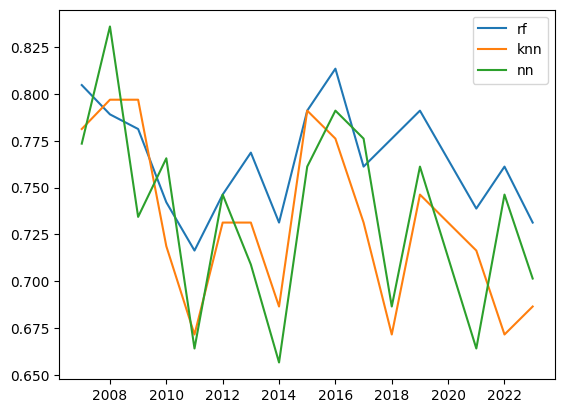

,model,year,train,test
0,rf,2023,0.959857,0.731343
1,knn,2023,1.0,0.686567
2,nn,2023,0.756467,0.701493
3,rf,2022,0.963472,0.761194
4,knn,2022,1.0,0.671642
5,nn,2022,0.775617,0.746269
6,rf,2021,0.962006,0.738806
7,knn,2021,1.0,0.716418
8,nn,2021,0.77001,0.664179
9,rf,2019,0.961957,0.791045


In [82]:
for model in final_results["model"].unique():
    plt.plot(final_results["year"][final_results["model"] == model], final_results["test"][final_results["model"] == model], label=model)
plt.legend()
plt.show()
final_results

In [57]:
rand_forest_hps = {
    "max_depth": [7 + i for i in range(6)] + [None],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2],
}
neural_net_hps = {
    "activation": ["relu"],
    "solver": ["lbfgs"],
    "max_iter": [3000],
    "hidden_layer_sizes": [30 + i for i in range(30)],
    "early_stopping": [True]
}
knn_hps = {
    "n_neighbors": [10 + i for i in range(10)],
    "weights": ["distance"]
}

# all_model_results = None
for i in trange(1000):
    lookback = np.random.choice([i+1 for i in range(10)])
    test_years = [2023 - i for i in range(19-lookback)]
    test_years.remove(2020)
    test_year = np.random.choice(test_years)
    if test_year > 2020:
        train_start = test_year - (lookback+1)
    elif test_year < 2020:
        train_start = test_year - lookback
    else:
        continue
    train_end = test_year - 1
    # print(lookback, train_start, train_end, test_year)
    model_key = np.random.choice(["rf", "knn", "nn"], p=[0, 0, 1])
    model = {"rf": RandomForestClassifier, "knn": KNeighborsClassifier, "nn": MLPClassifier}[model_key]
    hp_dict = {"rf": rand_forest_hps, "knn": knn_hps, "nn": neural_net_hps}[model_key]

    params = {}
    for hp in hp_dict:
        params[hp] = np.random.choice(hp_dict[hp])

    # print(lookback, train_start, train_end, test_year, model(params))
    train_score, test_score, _ = run_pipe(train_start, train_end, test_year, features, model=model, params=params)
    results = params.copy()
    results["train_score"] = train_score
    results["test_score"] = test_score
    results["train_start"] = train_start
    results["train_end"] = train_end
    results["test_year"] = test_year
    results["model_key"] = model_key
    # print(results)
    all_model_results = pd.concat((all_model_results, pd.DataFrame(results, index=[0])), axis=0)
all_model_results.head()

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [01:11<03:17,  2.50s/it]c:\Users\vauda\anaconda3\envs\madness\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 100/100 [07:09<00:00,  4.29s/it]


,n_neighbors,weights,train_score,test_score,train_start,train_end,test_year,model_key,max_depth,min_samples_split,min_samples_leaf,activation,solver,max_iter,hidden_layer_sizes,lookback,early_stopping
0,3.0,uniform,0.882812,0.625000,2008,2009,2010,knn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
0,NaN,NaN,0.848456,0.746269,2005,2012,2013,rf,5.0,4.0,1.0,NaN,NaN,NaN,NaN,7.0,NaN
0,NaN,NaN,0.756902,0.761194,2005,2014,2015,nn,NaN,NaN,NaN,relu,lbfgs,1000.0,7.0,9.0,NaN
0,NaN,NaN,0.500000,0.500000,2006,2011,2012,nn,NaN,NaN,NaN,relu,lbfgs,1000.0,3.0,5.0,NaN
0,NaN,NaN,0.729478,0.791045,2011,2014,2015,nn,NaN,NaN,NaN,relu,lbfgs,1000.0,3.0,3.0,NaN


In [60]:
all_model_results["lookback"] = all_model_results["train_end"] - all_model_results["train_start"]

C:\Users\vauda\AppData\Local\Temp\ipykernel_28968\581395655.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ser = all_model_results.groupby("hidden_layer_sizes").mean()["test_score"]
C:\Users\vauda\AppData\Local\Temp\ipykernel_28968\581395655.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ser2 = all_model_results.groupby("hidden_layer_sizes").mean()["train_score"]


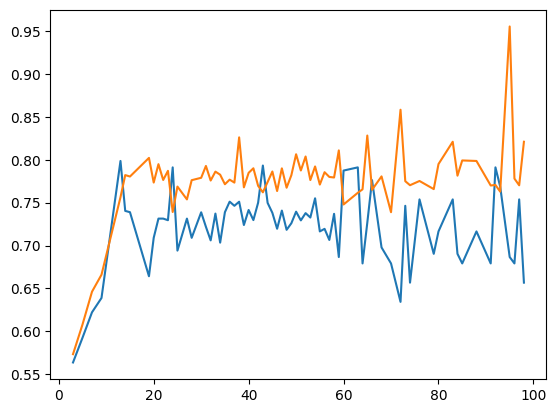

In [63]:
ser = all_model_results.groupby("hidden_layer_sizes").mean()["test_score"]
ser2 = all_model_results.groupby("hidden_layer_sizes").mean()["train_score"]
plt.plot(ser.index, ser)
plt.plot(ser2.index, ser2)
plt.show()

In [65]:
all_model_results.fillna("").groupby(["model_key", "min_samples_split", "min_samples_leaf"]).mean().sort_values("test_score", ascending=False)

C:\Users\vauda\AppData\Local\Temp\ipykernel_28968\1877158091.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_model_results.fillna("").groupby(["model_key", "min_samples_split", "min_samples_leaf"]).mean().sort_values("test_score", ascending=False)


train_score  test_score  train_start    train_end    test_year  lookback
model_key min_samples_split min_samples_leaf                                                                          
rf        4.0               2.0                  0.859263    0.742056  2010.413551  2015.544393  2016.544393  5.130841
                            3.0                  0.851892    0.740150  2010.686782  2015.589080  2016.589080  4.902299
          2.0               1.0                  0.871508    0.739990  2010.814208  2015.516393  2016.516393  4.702186
          4.0               1.0                  0.873589    0.739872  2010.665730  2015.561798  2016.561798  4.896067
          6.0               1.0                  0.848349    0.739686  2010.388451  2015.188976  2016.188976  4.800525
                            2.0                  0.849942    0.739339  2010.962963  2015.584046  2016.584046  4.621083
                            3.0                  0.849073    0.739035  2010.621483  2015.283887  2016.283887  4.662404
          2.0               3.0                  0.858621    0.736790  2010.989924  2015.821159  2016.821159  4.831234
                            2.0                  0.867769    0.736294  2010.893229  2015.585938  2016.585938  4.692708
knn                                              0.903025    0.707018  2010.721807  2015.438147  2016.438147  4.716341
nn                                               0.636642    0.614936  2010.864514  2015.551049  2016.551049  4.686534

In [64]:
all_model_results.fillna("").groupby(["model_key", "lookback"]).max().sort_values("test_score", ascending=False)

C:\Users\vauda\AppData\Local\Temp\ipykernel_28968\3069236458.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  all_model_results.fillna("").groupby(["model_key", "lookback"]).max().sort_values("test_score", ascending=False)


n_neighbors  weights  train_score  test_score  train_start  train_end  test_year min_samples_split min_samples_leaf activation solver max_iter hidden_layer_sizes
model_key lookback                                                                                                                                                                  
nn        1                                 0.955224    0.867188         2021       2022       2023                                          tanh  lbfgs   3000.0               98.0
          0                                 0.937500    0.851562         2018       2018       2019                                          tanh  lbfgs   3000.0               56.0
          7                                 0.798507    0.850746         2015       2022       2023                                          tanh  lbfgs   3000.0               92.0
rf        5                                 1.000000    0.843284         2017       2022       2023               6.0              3.0                                              
nn        6                                 0.803769    0.843284         2016       2022       2023                                          tanh  lbfgs   3000.0               85.0
rf        9                                 1.000000    0.843284         2013       2022       2023               6.0              3.0                                              
          6                                 1.000000    0.843284         2016       2022       2023               6.0              3.0                                              
nn        4                                 0.839552    0.843284         2018       2022       2023                                          tanh  lbfgs   3000.0               96.0
rf        1                                 1.000000    0.835938         2021       2022       2023               6.0              3.0                                              
nn        9                                 0.793130    0.835821         2013       2022       2023                                          tanh  lbfgs   3000.0               66.0
          3                                 0.858209    0.835821         2019       2022       2023                                          tanh  lbfgs   3000.0               91.0
rf        2                                 1.000000    0.835821         2020       2022       2023               6.0              3.0                                              
knn       8               28.0  uniform     1.000000    0.835821         2014       2022       2023                                                                                 
rf        8                                 1.000000    0.835821         2014       2022       2023               6.0              3.0                                              
          4                                 1.000000    0.828358         2018       2022       2023               6.0              3.0                                              
nn        5                                 0.817829    0.828358         2017       2022       2023                                          tanh  lbfgs   3000.0               97.0
rf        7                                 1.000000    0.820896         2015       2022       2023               6.0              3.0                                              
knn       9               27.0  uniform     1.000000    0.820896         2013       2022       2023                                                                                 
          5               26.0  uniform     1.000000    0.820896         2017       2022       2023                                                                                 
          4               27.0  uniform     1.000000    0.820896         2018       2022       2023                                                                                 
nn        8                          

In [ ]:
# rand_forest_hps = {
#     "max_depth": [None, 1, 3, 5],
#     "min_samples_split": [2, 4, 6],
#     "min_samples_leaf": [1, 2, 3],
# }
# neural_net_hps = {
#     "activation": ["logistic", "tanh", "relu"],
#     "solver": ["lbfgs"],
#     "max_iter": [100, 200],
#     "hidden_layer_sizes": [[9], [5], [6, 3], [7, 5, 3]]
# }
# knn_hps = {
#     "n_neighbors": [3, 5, 10],
#     "weights": ["uniform", "distance"]
# }
# # params = {}
# # for param in rand_forest_hps:
# #     params
# # params = {:4}
# # RandomForestClassifier(params)

# all_results = None
# for lookback in [5, 10]:
#     for test_year in [2023 - i for i in range(19-lookback)]:
#         if test_year > 2020:
#             train_start = test_year - (lookback+1)
#         elif test_year < 2020:
#             train_start = test_year - lookback
#         else:
#             continue
#         train_end = test_year - 1
#         print(train_start, train_end, test_year)

#         model = RandomForestClassifier
#         for max_depth in rand_forest_hps["max_depth"]:
#             for min_samples_split in rand_forest_hps["min_samples_split"]:
#                 for min_samples_leaf in rand_forest_hps["min_samples_leaf"]:
#                     params = {"max_depth": max_depth, "min_samples_split": min_samples_split, "min_samples_leaf": min_samples_leaf}
#                     clf = model(params)

#         model = MLPClassifier
#         for activation in neural_net_hps["activation"]:
#             for solver in neural_net_hps["solver"]:
#                 for max_iter in neural_net_hps["max_iter"]:
#                     for hidden_layer_sizes in neural_net_hps["hidden_layer_sizes"]:
#                         params = {"activation": activation, "solver": solver, "max_iter": max_iter, "hidden_layer_sizes": hidden_layer_sizes}
#                         clf = model(params)

#         model = KNeighborsClassifier
#         for n_neighbors in knn_hps["n_neighbors"]:
#             for weights in knn_hps["weights"]:
#                 params = {"n_neighbors": n_neighbors, "weights": weights}
#                 clf = model(params)
